# Figures

In [16]:
%load_ext autoreload
%autoreload 2

import collections
import os
import pathlib
import pickle

import joblib
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import powerlaw
import seaborn as sns
from tqdm.auto import tqdm

if 'project_dir' not in globals():
  project_dir = pathlib.Path.cwd().parent
os.chdir(project_dir)

import src.network.distance_distribution
from src.network.cooccurrence import Cooccurrence
import src.network.degree_histogram
import src.network.modularity
import src.network.giant_component
import src.progress_parallel

before_cleaning_file = 'data/2-merge/data.pkl'
data_file = 'data/3-process/data.pkl'
giant_component_file = 'networks/8/giant_component.pkl'
distance_distribution_file = 'networks/8/distance_distribution.txt'

network_file = 'networks/8/graph_attributes.pkl'
dutch_network_file = 'networks/8/dutch_graph_attributes.pkl'
dutch_data_file = 'data/3-process/rdw.pkl'
figure_file = 'reports/cn2019/Fig'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Figure 1

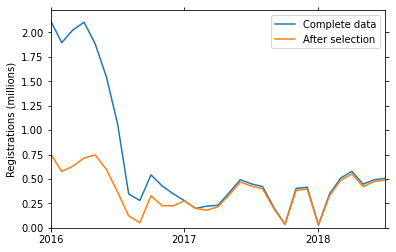

In [7]:
before = pd.read_pickle(before_cleaning_file)
before.dropna(subset=['entity'], inplace=True)
before.drop_duplicates(['entity', 'datetime'], ignore_index=True, inplace=True)
after = pd.read_pickle(data_file)

def convert(x):
  """Groupby month and divide by a million."""
  return ((x.dt.year + x.dt.month / 12).value_counts() / 1e6).sort_index()

with matplotlib.rc_context({'xtick.top': True, 'ytick.right': True}):
  pd.DataFrame(
    {
      'Complete data': convert(before['datetime']),
      'After selection': convert(after['datetime'])
    }
  ).plot(
    xticks=[2016, 2017, 2018], 
    ylabel='Registrations (millions)', 
    ylim=0, 
    xlim=(2016, 2018.5),
  )
  plt.savefig(figure_file + '1.pdf')

## Figure 2

In [42]:
before = pd.read_pickle(before_cleaning_file)
before.dropna(subset=['entity'], inplace=True)
before.drop_duplicates(['entity', 'datetime'], ignore_index=True, inplace=True)
after = pd.read_pickle(data_file)

def get_counts_bins(x: pd.Series, num_bins: int):
  frequency_list = x.value_counts().values
  bins = np.logspace(
    start=np.log10(1), 
    stop=np.log10(max(frequency_list)), 
    num=num_bins+1)
  counts, bins = np.histogram(frequency_list, bins=np.unique(np.round(bins)))
  return counts, bins

counts_before, bins_before = get_counts_bins(before['entity'], num_bins=8)
counts_after, bins_after = get_counts_bins(after['entity'], num_bins=8)

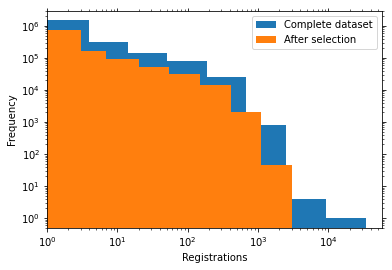

In [47]:
with matplotlib.rc_context({'xtick.top': True, 'ytick.right': True}):
  plt.bar(
    x=bins_before[:-1], 
    height=counts_before, 
    width=np.diff(bins_before), 
    align='edge', 
    label='Complete dataset')
  plt.bar(
    x=bins_after[:-1],
    height=counts_after,
    width=np.diff(bins_after),
    align='edge',
    label='After selection'
  )
  plt.xscale('log')
  plt.yscale('log')
  plt.xlim(1)
  plt.xlabel('Registrations')
  plt.ylabel('Frequency')
  plt.legend()
  plt.savefig(figure_file + '2.pdf')

## Figure 3

In [4]:
def density(x): 
  return np.bincount([codrive.timedelta.seconds for codrive in x]) / len(x)

systematic = pd.read_pickle('networks/16/cooccurrences.pkl')
random = pd.read_pickle('networks/16/randoms.pkl')

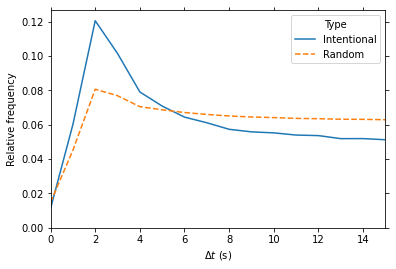

In [31]:
with matplotlib.rc_context({'xtick.top': True, 'ytick.right': True}):
  plt.plot(density(systematic), label="Intentional")
  plt.plot(density(random), label="Random", ls='--')
  plt.legend(title='Type')

  plt.xlabel(r"$\Delta t\ (\mathrm{s})$")
  plt.xlim(0,15)

  plt.ylabel("Relative frequency")
  plt.ylim(0)
  plt.savefig(figure_file + '3.pdf')

## Figure 4

In [6]:
def norm(x): return np.bincount(x).cumsum() / len(x)

between = dict()
for Δt_max in [4, 8, 16, 32]:
  systematics = pd.read_pickle(f'networks/{Δt_max}/cooccurrences.pkl')
  between[Δt_max] = norm(
    [cooccurence.timedelta.seconds for cooccurence in systematics])

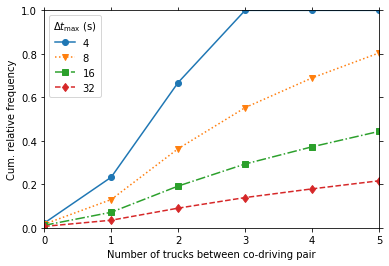

In [32]:
with matplotlib.rc_context({'xtick.top': True, 'ytick.right': True}):
  plt.plot(np.append(between[4], [1, 1]), ls="-", marker="o", label=4)
  plt.plot(between[8],  ls=":",  marker="v", label=8)
  plt.plot(between[16], ls="-.", marker="s", label=16)
  plt.plot(between[32], ls="--", marker="d", label=32)
  plt.xlim(0,5)
  plt.ylim(0,1)
  plt.legend(title=r"$\Delta t_\mathrm{max}\ \mathrm{(s)}$")
  plt.xlabel("Number of trucks between co-driving pair")
  plt.ylabel("Cum. relative frequency")
  plt.tick_params(top=True, right=True)
  plt.savefig(figure_file + '4.pdf')

## Table 1

In [18]:
g = pd.read_pickle(network_file)
gc = pd.read_pickle(giant_component_file)
distance_distribution = np.loadtxt(distance_distribution_file)

In [24]:
table1 = {
  'Number of nodes': g.number_of_nodes(),
  'Number of links': np.sum([attr for u, v, attr in g.edges(data='weight')]),
  'Number of connected node pairs': g.number_of_edges(),
  'Fraction nodes in giant component': (
    gc.number_of_nodes() / g.number_of_nodes()),
  'Fraction links in giant component': (
    np.sum([attr for u, v, attr in g.edges(data='weight')]) / 
    np.sum([attr for u, v, attr in gc.edges(data='weight')])
  ),
  'Density': nx.density(g),
  'Power law exponent $\gamma$': powerlaw.Fit(
    [d for _, d in g.degree], discrete=True, verbose=False).alpha,
  'Average shortest path length': (
    src.network.distance_distribution.average_distance(distance_distribution)),
  'Diameter': src.network.distance_distribution.diameter(distance_distribution)
}

In [25]:
pd.Series(table1)

Number of nodes                       37676.000000
Number of links                      131858.000000
Number of connected node pairs        51503.000000
Fraction nodes in giant component         0.699464
Fraction links in giant component         1.157685
Density                                   0.000073
Power law exponent $\gamma$               3.374934
Average shortest path length              6.785005
Diameter                                 26.000000
dtype: float64

## Figure 5

### Figure 5a

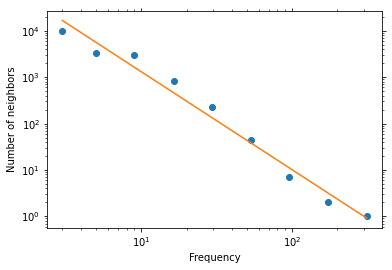

In [33]:
with matplotlib.rc_context({'xtick.top': True, 'ytick.right': True, }):
  x, y, y_fit = src.network.degree_histogram.degree_histogram(g)
  plt.scatter(x, y)
  plt.plot(x, y_fit, c='C1')
  plt.xscale('log')
  plt.yscale('log')
  plt.xlabel('Frequency')
  plt.ylabel('Number of neighbors')
  plt.savefig(figure_file + '5a.pdf')

### Figure 5b

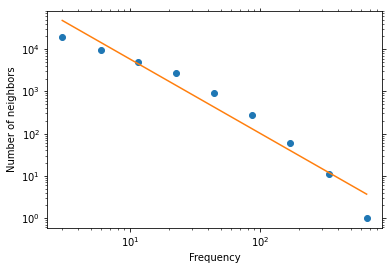

In [34]:
with matplotlib.rc_context({'xtick.top': True, 'ytick.right': True, }):
  x, y, y_fit = src.network.degree_histogram.degree_histogram(
    g, weight='weight')
  plt.scatter(x, y)
  plt.plot(x, y_fit, c='C1')
  plt.xscale('log')
  plt.yscale('log')
  plt.xlabel('Frequency')
  plt.ylabel('Number of neighbors')
  plt.savefig(figure_file + '5b.pdf')